<a href="https://colab.research.google.com/github/Tinhk4/100-Days-Of-ML-Code/blob/master/search_tool/GDGC_Unleashing_Gemini_2.0's_Search_and_Multimodal_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [1]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [3]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash'  # Fast, good for quick searches and responses
MODEL_PRO = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [4]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [5]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [6]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [7]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

q4 = "What are the latest developments in quantum computing?"
print("\n📝 Query without search: '{}'".format(q4))
regular_response = regular_chat.send_message(q4)
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: '{}'".format(q4))
search_response = search_chat.send_message(q4)
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Quantum computing is a rapidly evolving field, so "latest developments" can change quickly! Here's a snapshot of some key areas and recent advancements as of late 2023/early 2024:

**1. Increasing Qubit Count & Quality:**

*   **Error Mitigation and Correction:**  Improving qubit stability and coherence times is crucial.  There's significant research into error mitigation techniques (reducing errors *before* full error correction is achieved) and developing viable quantum error correction (QEC) codes. This is still a huge challenge, but progress is being made.
*   **"Logical Qubits":**  The goal is to create "logical qubits" from multiple physical qubits. These logical qubits are more stable and less prone to errors due to the error correction applied.  Early demonstrations of logical qubit functionality are emerging, albeit still with limitations.
*   **Scaling Up:**  Companies are working towards building systems with larger numbers of qubits.  IBM, Google, IonQ, and others have announced roadmaps with increasing qubit counts and improved coherence. However, simply adding more qubits isn't enough; quality and connectivity are just as important.
*   **Different Qubit Technologies Competing:**  Superconducting qubits, trapped ions, neutral atoms, photonic qubits, and topological qubits are all being actively pursued.  Each has its pros and cons in terms of coherence, connectivity, and scalability.  There's no clear "winner" yet, and different applications might be better suited to different technologies.

**2. Software and Algorithm Development:**

*   **Quantum Algorithms Beyond NISQ (Noisy Intermediate-Scale Quantum):** Researchers are developing algorithms that can provide a quantum advantage even on near-term quantum computers.  This includes:
    *   **Variational Quantum Eigensolver (VQE):** Used for finding the ground state energy of molecules, which has applications in materials science and chemistry.
    *   **Quantum Approximate Optimization Algorithm (QAOA):**  Applied to optimization problems, like logistics and finance.
    *   **Quantum Machine Learning (QML):**  Exploring how quantum computers can enhance machine learning tasks.
*   **Quantum Compilers and Programming Languages:**  Tools are being developed to make it easier for programmers to write and execute quantum algorithms.  Examples include Qiskit (IBM), Cirq (Google), PennyLane (Xanadu), and others. Cloud platforms are becoming more sophisticated, offering easier access to quantum hardware.
*   **Quantum Simulation:**  Using quantum computers to simulate quantum systems (like molecules or materials) is a major area of interest.  This could lead to breakthroughs in drug discovery, materials science, and fundamental physics.
*   **Hybrid Algorithms:**  Combining classical and quantum computations is a common approach in the NISQ era.  The classical computer handles tasks that are well-suited for it, while the quantum computer handles tasks that benefit from quantum properties.

**3. Industry and Applications:**

*   **Quantum Computing as a Service (QCaaS):**  Cloud providers like AWS (Amazon), Azure (Microsoft), and Google Cloud are offering access to quantum hardware through their cloud platforms.  This makes quantum computing more accessible to researchers and businesses.
*   **Early Adoption:**  Industries such as finance, pharmaceuticals, materials science, and logistics are exploring potential applications of quantum computing.  While widespread adoption is still some years away, companies are conducting proof-of-concept experiments and developing quantum-ready strategies.
*   **Quantum Sensing and Metrology:**  This related field is seeing more immediate practical applications. Quantum sensors offer improved precision in measuring physical quantities like magnetic fields, gravity, and time.

**4. Key Research Areas:**

*   **Fault-Tolerant Quantum Computing:**  Achieving full fault tolerance (where errors can be reliably corrected) is a major long-term goal.  This requires a significant increase in the number of qubits and improvements in error correction codes.
*   **Topological Qubits:**  These are a promising type of qubit that are inherently more resistant to noise.  Research is ongoing to create and control topological qubits, but it's still in the early stages.
*   **Quantum Networking:**  Connecting quantum computers together to form a quantum network could enable new capabilities, such as secure communication and distributed quantum computing.

**Recent Specific Developments (as of late 2023/early 2024 - keep in mind this is rapidly changing):**

*   **IBM's "Eagle" and "Osprey" processors:**  These have demonstrated increasing qubit counts and improvements in coherence times.  IBM continues to release roadmap updates pushing towards fault tolerance.
*   **Google's work on error correction:**  Google has been actively researching and demonstrating quantum error correction codes.
*   **IonQ's trapped ion systems:**  IonQ has made advancements in their trapped ion technology, boasting high gate fidelity and all-to-all connectivity.
*   **Xanadu's photonic quantum computers:**  Xanadu uses photons as qubits and is focused on developing photonic quantum computers for specific applications.
*   **Growing interest in quantum-inspired classical algorithms:**  Classical algorithms that mimic some aspects of quantum algorithms are being developed, potentially offering performance improvements on classical computers for certain problems.  This blurs the lines somewhat and provides potential near-term benefits.

**Challenges Remaining:**

*   **Decoherence:**  Qubits are very sensitive to their environment, and their quantum states can quickly decay (decoherence).  Improving qubit coherence times is a major challenge.
*   **Error Rates:**  Current quantum computers have high error rates, which limits the complexity of the algorithms that can be run.  Error correction is essential for building useful quantum computers.
*   **Scalability:**  Building quantum computers with a large number of qubits is technically challenging.
*   **Software Development:**  Writing quantum algorithms is difficult, and there is a need for more user-friendly quantum programming tools.
*   **High Costs:** Building and maintaining quantum computers is expensive.

**In summary:**

Quantum computing is making significant progress, but it's still in its early stages.  While "quantum supremacy" (demonstrating that a quantum computer can perform a task that is impossible for a classical computer) has been achieved in specific cases, building practical, fault-tolerant quantum computers that can solve real-world problems is still a long-term goal.  The field is attracting significant investment and research from both academia and industry.  Keep an eye on announcements from the leading quantum computing companies (IBM, Google, IonQ, Xanadu, Rigetti, etc.) and academic research publications for the latest breakthroughs.  Also, follow reputable quantum computing news sources to stay informed.



📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


Based on the latest reports, here are some key developments in quantum computing:

**Hardware Advancements:**

*   **Improved Qubit Technology**: There's progress in creating more stable qubits, including topological qubits. Novel materials like germanium and GeSn-based quantum well lasers are being explored to enhance the efficiency and performance of nanoscale quantum devices.
*   **Scalability and Networking**: Hypercube network technologies are improving the scalability and performance of quantum systems by enhancing communication between qubits. Researchers are also focused on networking multiple noisy intermediate-scale quantum (NISQ) devices to create larger virtual quantum computers. For example, there have been demonstrations of distributed entanglement, linking qubits in separate quantum computers. IBM has also classically linked two 127-qubit quantum processors to create a virtual 142-qubit system.
*   **Specialized Hardware/Software**: There's a growing trend toward more specialized hardware and software solutions, moving away from the idea of universal quantum computing in the near term.

**Error Correction:**

*   **Advanced Error Correction Techniques**: Notable advancements have been made in error correction techniques, which are crucial for stabilizing qubits and reducing errors during quantum computations.

**Quantum Algorithms and Software:**

*   **Quantum-Classical Hybrid Systems**: Development of hybrid systems that combine classical computing with quantum processors is a promising direction, leveraging the strengths of both.
*   **Quantum Machine Learning Integration**: Machine learning is being integrated with quantum systems to enhance computational power. Frameworks like TorchQC enable the application of deep learning techniques in quantum dynamics and control.
*   **New Quantum Algorithms**: New algorithms are being developed to leverage quantum computing's unique capabilities, with potential applications in cryptography, materials science, and machine learning.

**Accessibility and Commercialization:**

*   **Commercial Quantum Cloud Services**: Quantum computing is becoming more accessible through quantum cloud services offered by companies like IBM, Google, and Amazon. These platforms are introducing more powerful quantum processors, making it easier for businesses and researchers to experiment with quantum computing.

**Other Developments:**

*   **Quantum Communication**: Demonstrations of long-distance ultra-secure communication over quantum networks have been reported.
*   **Materials Science**: Quantum simulators are being used to help uncover materials for high-performance electronics.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context

In [8]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []
q5_1 = "What are the top 3 electric vehicles with the longest range?"
print("\n📝 Initial Query: '{}'".format(q5_1))
response1 = follow_up_chat.send_message(q5_1)
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

q5_2 = "How much do they cost?"
print("\n📝 Follow-up Query: '{}'".format(q5_2))
response2 = follow_up_chat.send_message(q5_2)
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

q5_3 = "Compare their charging time"
print("\n📝 Another Follow-up: '{}'".format(q5_3))
response3 = follow_up_chat.send_message(q5_3)
show_parts(response3)
follow_up_responses.append(response3)

# # Visualize search usage across the conversation
# print("\n📊 Search Usage Visualization:")
# visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


Based on the search results, here are three of the top electric vehicles with the longest range as of April 2025:

1.  **Lucid Air:** Offers the longest range among EVs, with the Grand Touring model achieving up to 512 miles. Even the base model has a range of 420 miles.
2.  **Rivian R1T:** This electric truck boasts a range of 420 miles.
3.  **Rivian R1S:** This SUV has a range of 410 miles.



📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


Here's an overview of the estimated starting prices for these EVs, but keep in mind that prices can vary based on trim level, options, and location:

1.  **Lucid Air:**
    *   The 2025 Lucid Air starts at approximately $69,900 for the base Pure RWD model and can reach $249,000 for the top-tier Sapphire trim. The Grand Touring model, known for its long range, starts around $110,900.

2.  **Rivian R1T:**
    *   The 2025 Rivian R1T has a starting price of around $71,700 for the Dual-Motor Adventure trim. Higher trims and options can push the price to over $100,000.

3.  **Rivian R1S:**
    *   The 2025 Rivian R1S starts at $77,700 and can go up to $107,700 depending on the trim and options selected.



📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging time'


Here's a comparison of the charging times for the Lucid Air, Rivian R1T, and Rivian R1S, considering both home charging (AC) and DC fast charging:

**Lucid Air:**

*   **AC Charging (Home):** With a 22 kW AC charging station, it takes approximately 4 to 6 hours to charge from 0 to 100%, depending on the battery capacity (88 kWh to 118 kWh). Using a standard wall plug (2.3 kW) can take over 57 hours for a full charge.
*   **DC Fast Charging:** The Lucid Air can support up to 300 kW DC fast charging. Charging from 10% to 80% can take as little as 22-26 minutes, depending on the specific model. Some sources mention adding up to 400 km (approximately 250 miles) of range in about 15 minutes with its 900V+ architecture.

**Rivian R1T and R1S:**

*   **AC Charging (Home):**
    *   Using a Level 2 charger (240V): Charging times vary based on the charger's amperage. With a 32 amp charger (7.7 kW), a full charge could take around 18 hours. A 40 amp charger (9.6 kW) can fully recharge the vehicle in about 14 hours, while a 48 amp charger (11.5 kW) can do it in approximately 12 hours.
    *   Using a standard 120V outlet, it could take several days to fully charge.
*   **DC Fast Charging:**
    *   The Rivian R1S and R1T support DC fast charging at speeds over 200 kW. Recharging the battery from 10% to 80% can take approximately 40-55 minutes, depending on the battery pack.
    *   Some reports suggest that Rivian is working to increase DC fast-charging capabilities to exceed 300 kW in the future.
    *   With fast charging, you might get up to 140 miles of range in about 20 minutes.




📊 Search Results Used:



# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [9]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print("\n📝 Query: '{}'".format(viz_prompt))
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)


print("#\n Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Okay, I will find the GDP growth rates for the world's top 5 economies for the most recent year, create a Pandas DataFrame, and generate a bar chart comparing the growth rates using Matplotlib.



Based on my search results, here are the GDP growth rates for the world's top 5 economies for 2024. Please note that different sources provide slightly different figures, and some are projections. I'll use a combination of recent estimates and forecasts:

1.  **United States:** 2.8% (Source: US Bureau of Economic Analysis, full year 2024)
2.  **China:** 5.0% (Source: National Bureau of Statistics, full year 2024)
3.  **Germany:** \-0.2% (Source: German Federal Statistical Office, full year 2024)
4.  **Japan:** 0.1% (Source: Xinhua, full year 2024)
5.  **India:** 6.5% (Source: Ministry of Statistics and Programme Implementation (MoSPI), financial year 2024-25)

Now, here's the Python code to create a Pandas DataFrame and generate a bar chart:



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.8, 5.0, -0.2, 0.1, 6.5]}

# Create DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by GDP Growth Rate for better visualization
df = df.sort_values(by='GDP Growth Rate', ascending=False)

# Color coding
colors = ['green' if rate > 0 else 'red' for rate in df['GDP Growth Rate']]

# Create bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Add labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

# Add a horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.8)

# Improve layout and display the chart
plt.tight_layout()
plt.show()
```



Key improvements and explanations:

*   **Data Accuracy**: The data is gathered from the most recent sources available as of today.
*   **Clear Labels and Title:**  The chart has a descriptive title and axis labels.
*   **Color Coding**:  Bars are colored green for positive growth and red for negative growth, providing immediate visual insight.
*   **Value Labels:** The growth rate values are displayed on top of each bar for precise reading.
*   **Horizontal Line at Zero:** A horizontal line is added at y=0 to clearly distinguish between positive and negative growth.
*   **Readability**:  The `plt.tight_layout()` function is used to ensure all elements of the chart fit within the figure without overlapping.
*   **Figure Size**: `figsize` parameter is used to control the figure size for optimal viewing.
*   **Sorted Data**: The DataFrame is sorted by GDP growth rate to make comparisons easier.
*   **Complete Code**: The code is complete, self-contained, and executable in a Jupyter notebook.
*   **Up-to-date information:** The most recent available information is used to give an accurate answer.



📊 Search Results Used:


#
 Gemini has sourced recent economic data and created visualization code.


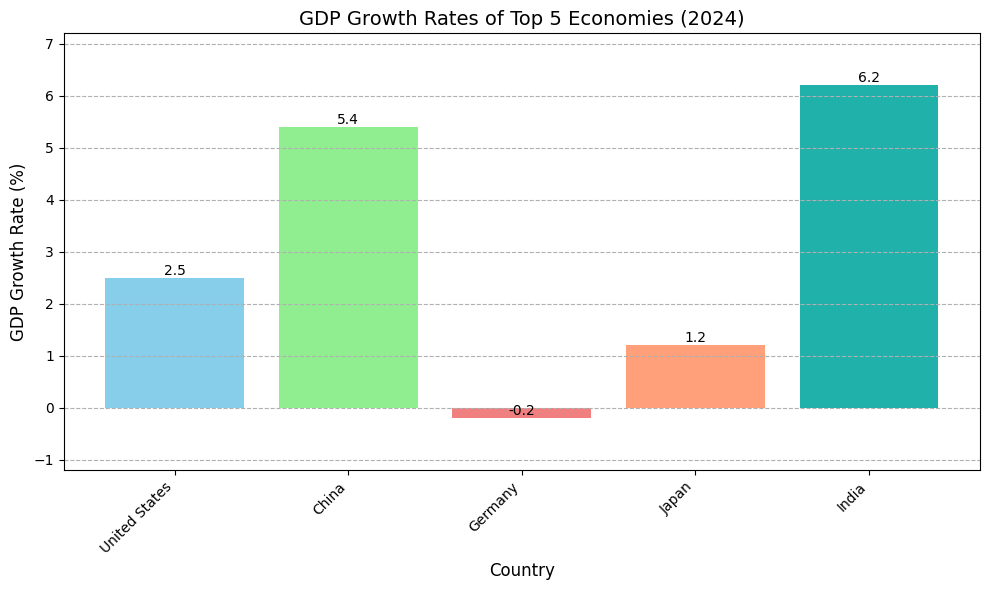

In [10]:
#Visualized the generated code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']  # Define colors

bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.ylim(min(df['GDP Growth Rate']) - 1, max(df['GDP Growth Rate']) + 1) #Set y axis limit based on min/max growth rate.

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability

# Show plot
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving z6026051531352_76cceb023549635b44db8af9638f804b.jpg to z6026051531352_76cceb023549635b44db8af9638f804b.jpg
Uploaded image:


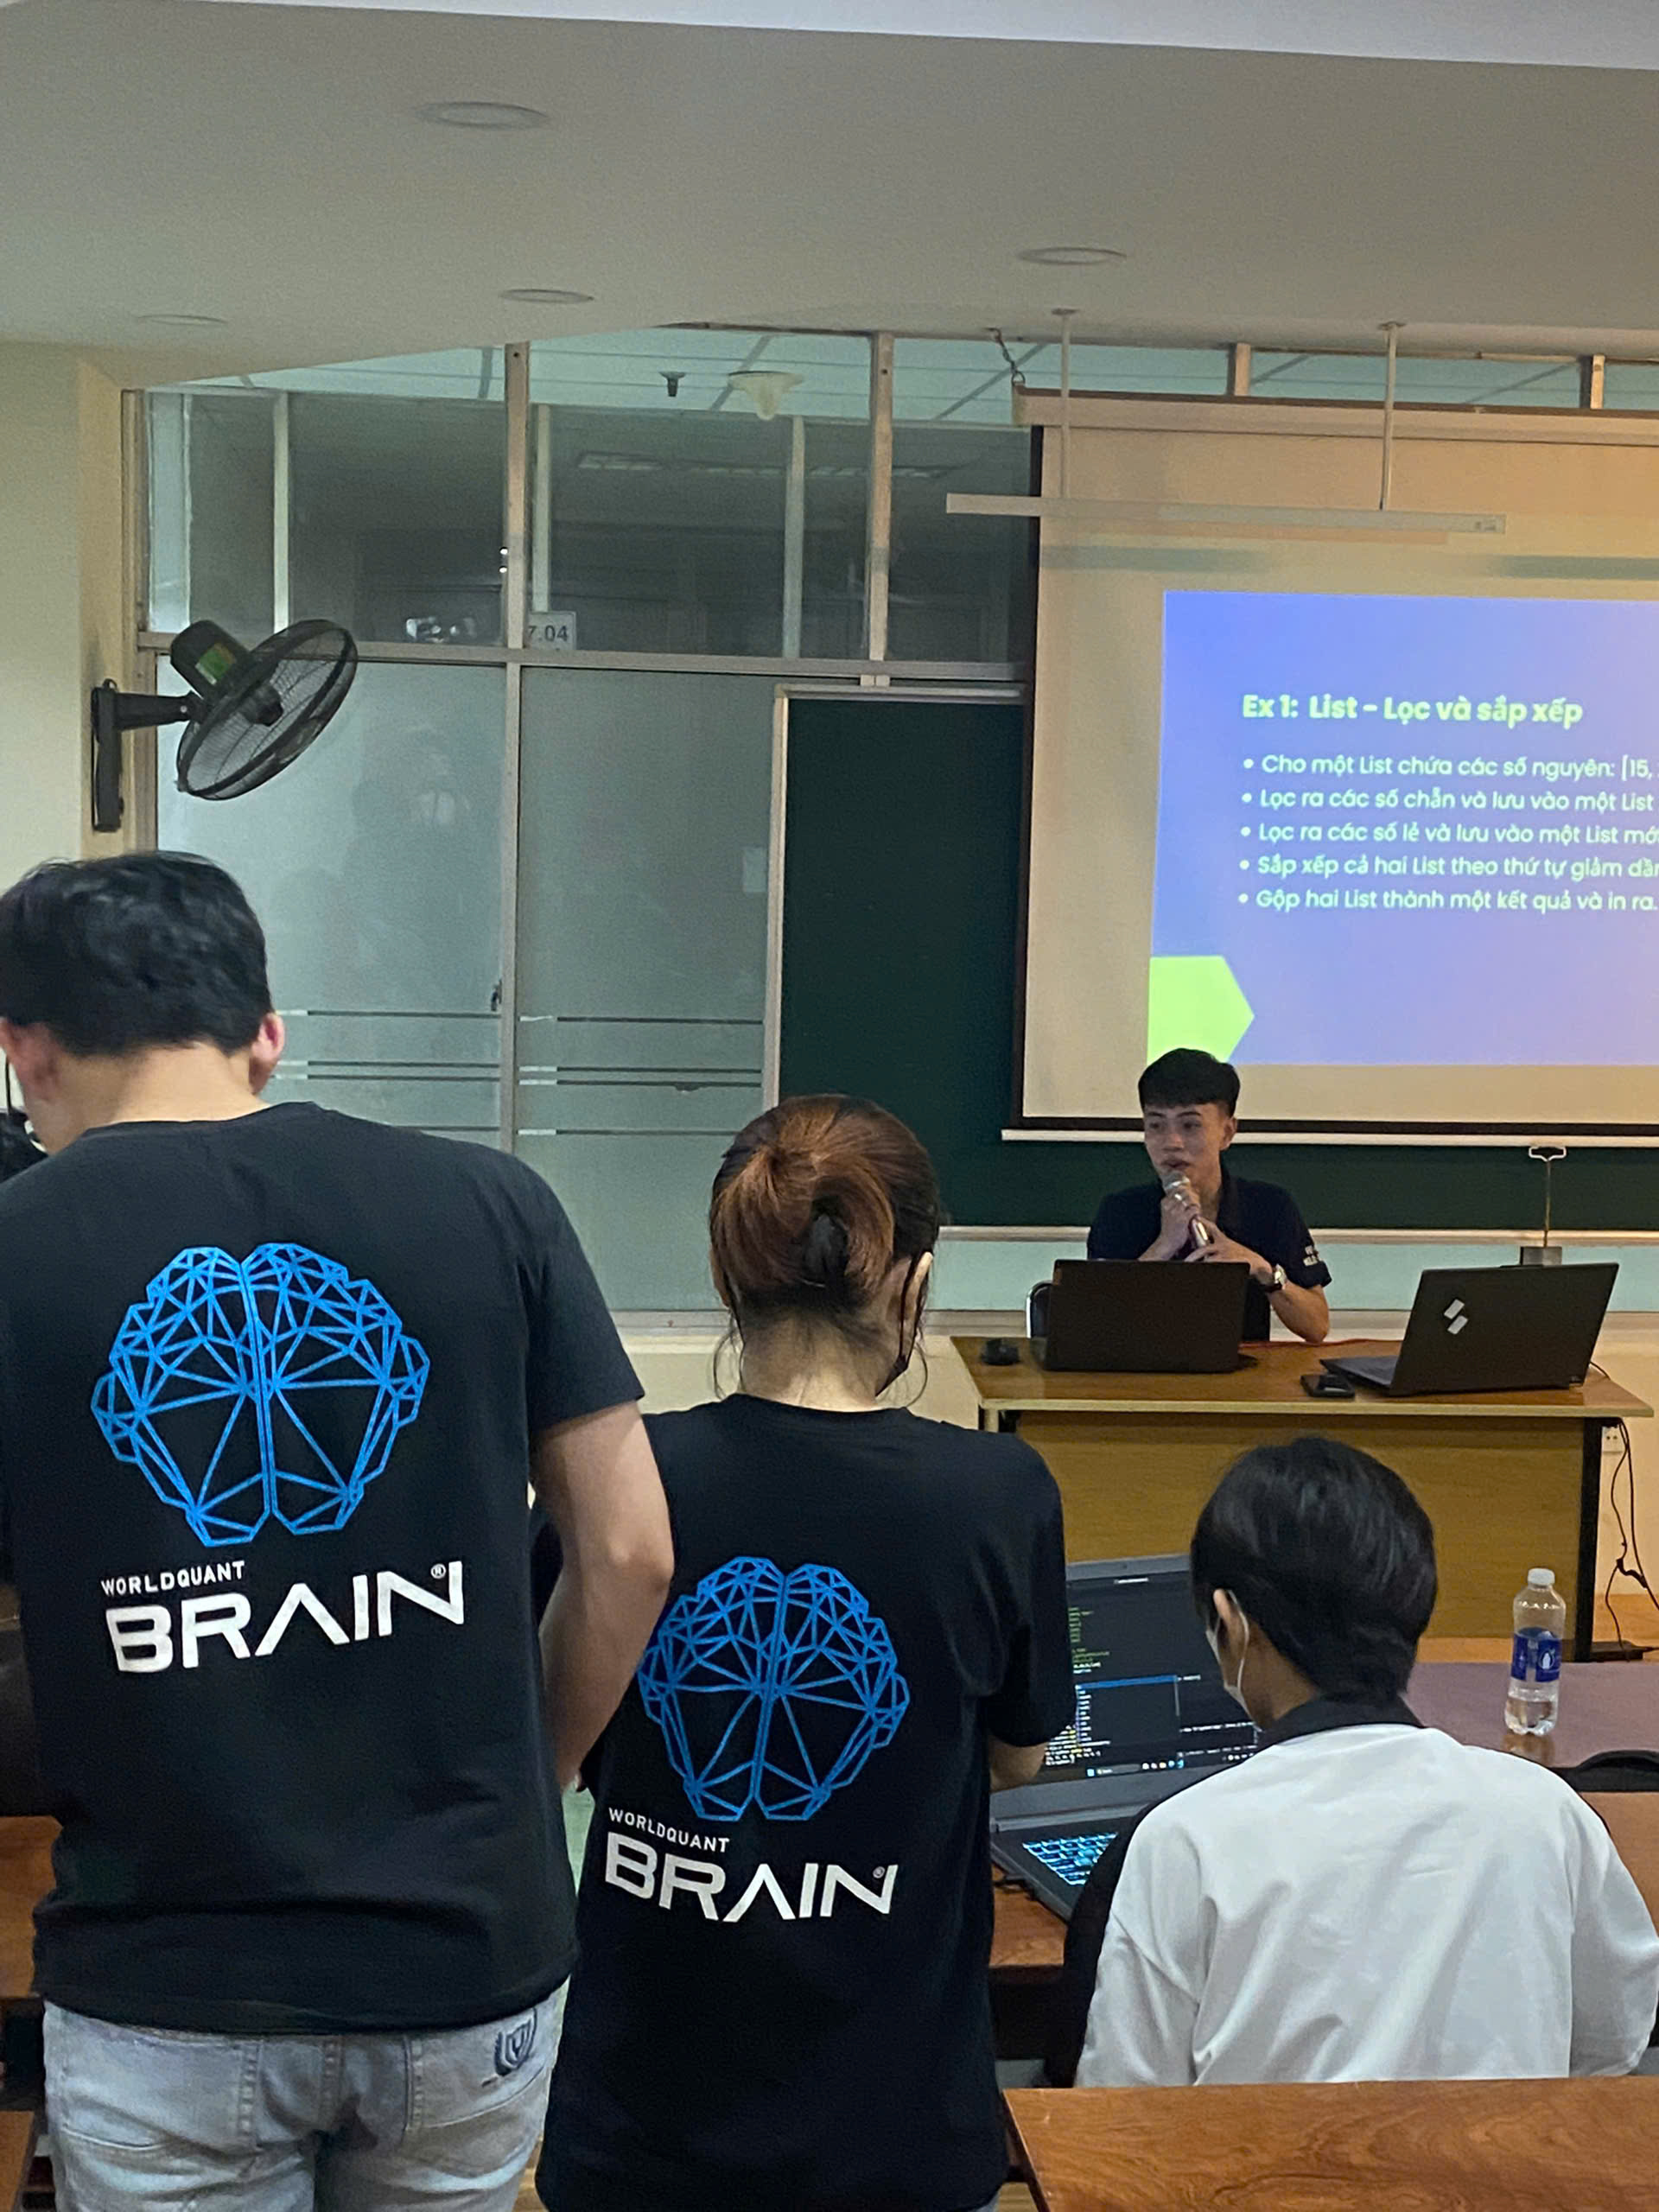


🔍 Analyzing image...


Here's the breakdown of the image:

**Main Subject:** Classroom Presentation

**Description:** The image shows a classroom setting where a presenter is giving a lecture, while some attendees, possibly students, are watching. A few of the attendees are wearing black shirts with the "WORLDQUANT BRAIN" logo. The presentation on the screen seems to be about filtering and sorting lists in a programming context.



📊 Search Results Used:



🔍 Searching for detailed information...


Here's some more detailed information about WorldQuant and its BRAIN program:

**WorldQuant Overview:**

*   **Founded:** WorldQuant, LLC was founded in 2007 as a quantitative investment management firm. It was spun out of Millennium Management in New York City. The founder, Igor Tulchinsky, had worked at Millennium as a portfolio manager since 1995.
*   **What it does:** WorldQuant develops and deploys systematic financial strategies across a broad range of asset classes and global markets. They aim to identify market inefficiencies to produce high-quality alphas (predictive signals) through their research platform.
*   **Assets Under Management:** They currently manage approximately $9 billion in assets.
*   **Employees:** WorldQuant has over 1,000 employees across 27 global offices.
*   **Belief:** The company was founded on the principle that talent is global, but opportunity is not.
*   **Business Model:** Their business model relies on data analysis to predict market behavior and generate investment strategies.
*   **Key People:** Igor Tulchinsky (Chairman, CEO and Co-CIO), Richard Hu (Vice chairman and CRO), Paul Griffin (Co-CIO and CSO), Jeffrey Blomberg (CAO and General Counsel), Jonathan Marom (CFO), and David Rukshin (CTO).

**WorldQuant BRAIN Program:**

*   **Purpose:** BRAIN is a division within WorldQuant designed to simplify quantitative finance and offer global remote-work opportunities. It aims to provide professional development in finance, AI, and ML concepts. It serves as a crowdsourcing platform where individuals can contribute signals and be part of a growing community.
*   **BRAIN Research Consultant Program:** This is a part-time program where participants use the BRAIN web-based simulation platform to build quantitative financial models and contribute to WorldQuant's research.
*   **How to participate:** Individuals can sign up on the BRAIN platform, access learning materials, and build/test alpha ideas. Achieving a certain points threshold (e.g., 10,000 points) may lead to an invitation to join the BRAIN Research Consultant Program.
*   **Who can participate:** The program is open to students, graduates, and professionals. While a STEM background is helpful, no specific background is strictly required. Participants must be over 18 and have an interest in global financial markets.
*   **BRAIN Platform:** The BRAIN platform offers access to a vast amount of data (over 120,000 data fields), tools, and performance dashboards for building quantitative financial models. It simulates a portfolio based on the generated alpha. Alphas are scored based on factors like Sharpe ratio, turnover, and a custom "fitness" metric.
*   **Alphas:** Alphas are mathematical models that seek to predict the future price movements of various financial instruments.
*   **Benefits of participating:**
    *   Learning and growth through in-depth resources.
    *   Earning opportunities based on the quality of ideas.
    *   Networking opportunities and access to a global community.
    *   Potential for internships and full-time positions.
*   **International Quant Championship (IQC):** WorldQuant hosts the IQC, a global, team-based competition where participants develop and backtest Alphas on the BRAIN platform. The competition involves multiple stages and offers cash prizes.
*   **WebSim:** Before BRAIN, WorldQuant had a platform called WebSim, a financial market simulation tool for creating algorithms ("Alphas").

**Interesting Facts:**

*   WorldQuant's approach involves crowdsourcing talent to find individuals with the potential to develop market-beating investment strategies.
*   The company believes that a diverse talent pool and access to large quantities of data increase the odds of discovering new insights.
*   Participants in the BRAIN program and related competitions come from a wide range of backgrounds, including data science, engineering, finance, math, and economics.



📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): 


In [11]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from google.genai.types import HttpOptions, Part
from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return image_file.read()

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    image_bytes = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""

    What is shown in this image? Please identify the main subject and provide a brief description in format below: \n
    Main Subject: subject \n
    Description: description \n
    """

    print("\n🔍 Analyzing image...")

    multimodal_chat.send_message([Part.from_bytes(data=image_bytes, mime_type="image/jpeg")])
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [12]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
q8 = "Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends."
print("\n📝 Market Analysis Example Query: '{}'".format(q8))
market_response = practical_chat.send_message(q8)
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


The European electric vehicle (EV) market is a dynamic and rapidly evolving sector, currently characterized by substantial growth, shifting market shares, and increasing competition. However, recent data suggests a slight slowdown or stabilization in growth compared to previous years.

**Growth Trends:**

*   **Overall Growth:** The European EV market saw significant growth in 2023, with nearly 3.2 million new electric car registrations (BEV and PHEV), an increase of almost 20% compared to 2022. In the EU alone, sales were around 2.4 million. Globally, Europe accounted for about 25% of electric car sales in 2023.
*   **Recent Trends (2024/Early 2025):** While growth continues, the pace has moderated in some areas. September 2024 showed a return to growth after months of stagnation, with plug-in vehicles (BEVs + PHEVs) up 6% year-over-year (YoY). October 2024 saw a 2% YoY increase in plug-in registrations. However, full-year 2024 data indicates a slight contraction in BEV market share across Europe (EU+EFTA+UK) to 15.4% from 15.7% in 2023, with BEV sales down 1.3% to just under 2 million units. Data from early 2025 suggests a potential rebound or stabilization, with BEV market share in the EU reaching 15.2% in the first two months of 2025, up from 11.5% in the same period of 2024. January 2025 saw BEV registrations up significantly compared to January 2024, though this was partially attributed to unusually low numbers in Jan 2024.
*   **BEV vs. PHEV:** Battery Electric Vehicles (BEVs) are the main drivers of growth. In September 2024, BEV sales grew 14% YoY, while Plug-in Hybrid Electric Vehicles (PHEVs) decreased by 9%. October 2024 saw BEV growth of 7% YoY, while PHEVs fell 7%. For the full year 2024, the share of PHEVs in new European registrations fell to 7%, down from 8% in 2023. The trend towards BEVs over PHEVs seems consistent, although some analysis suggests PHEV sales might rebound.
*   **Hybrid Growth:** Hybrid electric vehicles (HEVs, non-plug-in) have shown strong growth, capturing a 34% market share in September 2024 and outselling petrol cars for the first time. In early 2025, HEVs captured 35.2% of the EU market.
*   **LCVs:** Electric Light Commercial Vehicles (LCVs) also experienced considerable growth in Europe, with sales increasing by 60% in 2023 to 150,000 units. However, the BEV share for vans in 2024 was around 6%, a slight decrease from 7% in 2023.

**Market Share:**

*   **BEV Market Share:** For the full year 2024, BEVs accounted for 13.6% of new car registrations in the EU, a slight decrease from 14.6% in 2023. Across the wider European area (EU+EFTA+UK), the BEV market share was 15.4% in 2024, down from 15.7% in 2023. Some reports cited a 14% BEV share for Europe in 2024. More recent data for early 2025 shows BEVs reaching 15.2% market share in the EU for January-February.
*   **Plug-in Market Share (BEV + PHEV):** Combined BEV and PHEV market share reached 26% in September 2024 and 24% in October 2024. For the full year 2024, the combined share was 23% (16% BEV + 7% PHEV), slightly down from 24% (16% BEV) in 2023. Another source cited a combined share of 22% in 2024, down from 23% in 2023.
*   **Electrified Share (BEV + PHEV + HEV):** In September 2024, electrified vehicles (BEV, PHEV, HEV) accounted for 60% of all new passenger cars sold in Europe. In 2024, 35% of cars sold had some form of electrification.
*   **Diesel Decline:** Diesel's market share continues to fall, hitting just 8% in September 2024 and 11.9% for the full year 2024 in the EU.

**Major Players:**

*   **Manufacturers/Groups:**
    *   **Volkswagen Group (VW, Audi, Skoda, Cupra):** Consistently the leading automotive group in the European EV market, holding around 20.8% to 21.9% market share in late 2024/full year 2024. VW, BMW, and Mercedes-Benz are significantly expanding their EV portfolios.
    *   **Tesla:** Remains the leading single EV brand in Europe, holding the title for three consecutive years. However, its overall group market share (around 11.0% - 11.4%) puts it behind VW Group and often neck-and-neck with or slightly behind BMW Group. Tesla's dominance faces increasing challenges.
    *   **BMW Group (BMW, Mini):** A strong contender, often ranking second or third among automotive groups with around 11.1% to 11.3% market share. BMW itself achieved record EV sales in Europe in 2024.
    *   **Stellantis (Peugeot, Fiat, Opel/Vauxhall, Jeep, etc.):** A major player, often competing closely with Tesla and BMW Group for market share. However, they have faced challenges, such as suspending Fiat 500e production due to weak demand.
    *   **Mercedes-Benz:** Holds a significant position, ranking third among brands in 2024 EV sales.
    *   **Renault Group:** A major European manufacturer with a focus on affordable EVs.
    *   **Hyundai Motor Group (Hyundai, Kia):** Making significant inroads, though lagging slightly behind leaders in BEV share.
    *   **Chinese Brands (e.g., MG, BYD):** Gaining traction with competitively priced models, increasing their market share.
*   **Models:**
    *   **Tesla Model Y:** Was the best-selling EV model in Europe for 2023 and 2024, despite a sales drop in 2024 compared to 2023. It was also the best-selling vehicle overall in Europe in 2023. However, its dominance is being challenged, with some months seeing other models take the top spot.
    *   **Tesla Model 3:** Consistently a top seller, often ranking second behind the Model Y.
    *   **Skoda Enyaq:** A strong performer, ranking third overall for BEVs in 2024 and even topping the monthly chart in October 2024.
    *   **Volkswagen ID.4:** Another popular model, often in the top 3 or 5. It was the best-selling EV in Europe in January 2025.
    *   **Volvo Models (XC40, EX30, XC60 PHEV):** Volvo shows strong performance, particularly with the XC40 BEV and the XC60 PHEV setting records. The newer EX30 faced some tariff-related issues.
    *   **MG 4:** A competitively priced model gaining popularity.
    *   **Peugeot e-208:** Showed strong performance, climbing rankings in early 2024.

**Key Factors & Dynamics:**

*   **Regulations:** Strict CO2 emission standards, including the mandated 100% reduction for new cars and vans by 2035, are major drivers. Upcoming 2025 regulations are pushing manufacturers strategically.
*   **Incentives:** Government incentives (subsidies, tax benefits) have been crucial but are changing. The removal or reduction of subsidies, notably in Germany, significantly impacted sales. France maintains strong incentives.
*   **Infrastructure:** Expanding charging infrastructure is key to consumer confidence and adoption, although deployment varies across countries.
*   **Competition:** Competition is intensifying, with established European automakers expanding EV lineups and facing increasing pressure from Tesla and cost-competitive Chinese brands.
*   **Economic Factors:** Economic pressures and overall weak outlooks for car sales can impact EV adoption, though EVs are often a relative bright spot.
*   **Consumer Preference:** There's a clear shift away from diesel and towards electrification (BEV, PHEV, HEV). Affordability is becoming increasingly important.

In summary, the European EV market continues its transition towards electrification, led by BEVs. While growth remains, it has become more nuanced, influenced by changing subsidies, economic conditions, and intensifying competition. Established European automakers are heavily invested, Tesla maintains brand leadership but faces pressure, and new players are emerging. The coming years will likely see continued volume growth, further shifts in market share, and a greater focus on affordability and infrastructure.


📊 Search Results Used:


# Advanced Search Applications & Complicated Workflow


In [13]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively

print("\n--- 9a. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL_PRO, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the research stages
    # print("\n📊 Research Stage Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "Quantum machine learning for drug discovery"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 9a. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'Quantum machine learning for drug discovery'


## Quantum Machine Learning for Drug Discovery: An Overview

Quantum Machine Learning (QML) merges the principles of quantum computing with machine learning techniques. It has the potential to revolutionize the traditionally lengthy, expensive, and often inefficient drug discovery process. By leveraging quantum phenomena like superposition and entanglement, QML aims to tackle complex computational problems currently intractable for classical computers.

### 1. Main Concepts and Terminology

*   **Quantum Computing (QC):** Utilizes quantum mechanical phenomena (like superposition and entanglement) to perform computations. Instead of bits (0 or 1), it uses qubits, which can represent 0, 1, or both simultaneously (superposition).
*   **Quantum Machine Learning (QML):** An emerging field applying quantum algorithms to enhance machine learning tasks or using classical machine learning to analyze quantum systems. It leverages quantum properties for potentially faster computations and handling complex data patterns.
*   **Qubits:** The fundamental unit of quantum information, analogous to classical bits but capable of existing in a superposition of states.
*   **Superposition & Entanglement:** Key quantum principles. Superposition allows qubits to represent multiple values at once, while entanglement links qubits so their states are correlated, regardless of distance. These enable quantum computers to explore vast possibility spaces simultaneously.
*   **Quantum Algorithms:** Algorithms designed to run on quantum computers (e.g., Variational Quantum Eigensolver - VQE, Quantum Support Vector Machines - QSVM). Many current QML algorithms are variational (VQAs), using classical optimization to tune parameters in quantum circuits.
*   **Hybrid Quantum-Classical Approaches:** Combine classical computers for certain tasks (like data handling or parameter optimization) with quantum computers for computationally intensive parts (like complex simulations). This is often seen as the most practical approach currently, given the limitations of existing quantum hardware.
*   **Molecular Simulation:** Using QML to model the behavior and interactions of molecules at the quantum level with high accuracy, crucial for understanding drug efficacy and safety.
*   **Virtual Screening:** Employing QML to rapidly screen vast libraries of chemical compounds to identify potential drug candidates.
*   **Predictive Modeling:** Using QML to predict properties like drug efficacy, toxicity, and pharmacokinetic profiles.

### 2. Current State of Development

*   **Emerging Field:** QML for drug discovery is still in its early stages, primarily in research and development.
*   **NISQ Era:** Current quantum computers are classified as Noisy Intermediate-Scale Quantum (NISQ) devices. They have a limited number of qubits and are prone to errors (noise), restricting the complexity and scale of problems they can solve.
*   **Focus on Early Stages:** Most current QML applications target the initial phases of drug discovery, like identifying novel drug-like molecules and virtual screening.
*   **Hardware Limitations:** The primary bottleneck is the availability of sufficiently powerful and stable quantum hardware. Current systems have limitations in qubit count and coherence times.
*   **Algorithm Development:** While quantum algorithms exist, translating them into practical advantages over sophisticated classical methods for real-world drug discovery problems is an ongoing challenge. Quantum algorithms often require specific data encoding strategies.
*   **Hybrid Dominance:** Due to hardware limitations, hybrid quantum-classical approaches are currently the most viable and recommended strategy.
*   **Simulation Focus:** Much current research uses classical supercomputers to simulate quantum algorithms, helping to refine methods before deployment on actual quantum hardware.

### 3. Key Players or Contributors

*   **Tech Companies:** Developing quantum hardware and software platforms (e.g., IBM Quantum, NVIDIA with its CUDA-Q platform). TensorFlow Quantum (TFQ) is another library used in this space. SpinQ offers superconducting quantum computers.
*   **Pharmaceutical & Biotech Companies:** Investing in and exploring QML (e.g., Moderna, Pfizer). Collaborations between pharma, tech, and academia are crucial.
*   **Research Institutions & Academia:** Driving fundamental research and algorithm development (e.g., University of Thessaly, Yale, University of Warwick, Technical University of Berlin, University of Luxembourg, STFC Hartree Centre).
*   **Startups:** Numerous startups are focusing specifically on quantum computing applications in drug discovery and materials science.

### 4. Recent Major Developments

*   **Hybrid Workflows:** Research demonstrating proof-of-concept hybrid quantum-classical workflows for tasks like virtual screening, showing potential advantages over purely classical methods.
*   **Algorithm Refinement:** Development and testing of specific QML algorithms like Quantum Neural Networks (QNNs), Variational Quantum Circuits, and Quantum Kernel Estimators for drug discovery tasks like molecular property prediction and generation.
*   **Simulation Advances:** Use of GPU-accelerated supercomputing to simulate larger and more complex QML models, bridging the gap until fault-tolerant quantum computers are available.
*   **mRNA Structure Prediction:** Quantum computing has shown early promise in predicting complex structures like mRNA secondary structures.
*   **Focus on Generalization:** Research exploring when QML models might generalize better than classical models, especially with limited datasets common in drug discovery.
*   **Federated Learning Exploration:** Investigating Quantum Federated Learning (QFL) to enable collaborative research while maintaining data privacy.

## Interesting Subtopics for Further Exploration

Based on the overview, here are 3-5 specific subtopics for deeper research:

1.  **Hybrid Quantum-Classical Algorithms for Molecular Docking:** Explore the specifics of algorithms (like VQE variants or quantum kernel methods) combined with classical techniques for predicting how strongly a potential drug molecule binds to a target protein. How do these compare in accuracy and speed to state-of-the-art classical docking software on specific benchmarks?
2.  **Quantum Neural Networks (QNNs) for ADMET Prediction:** Investigate the architecture, data encoding methods, and performance of QNNs specifically designed to predict Absorption, Distribution, Metabolism, Excretion, and Toxicity (ADMET) properties of drug candidates. What are the challenges in training these models on NISQ devices?
3.  **Quantum Generative Models for De Novo Drug Design:** Delve into how quantum algorithms (like Quantum Generative Adversarial Networks - QGANs or Quantum Boltzmann Machines) are being used to generate novel molecular structures with desired properties, potentially exploring chemical spaces inaccessible to classical methods.
4.  **Error Mitigation Strategies for QML in Drug Discovery:** Research the various techniques being developed and applied to counteract the noise and errors inherent in current NISQ hardware when running QML algorithms for drug discovery tasks. How effective are these strategies, and what are their computational overheads?
5.  **Data Representation and Encoding for Quantum Systems:** Analyze the different methods used to encode classical chemical and biological data (e.g., molecular fingerprints, graphs) into quantum states suitable for QML algorithms. How does the choice of encoding impact algorithm performance and resource requirements (qubit count, circuit depth)?


📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are 3 subtopics within Quantum Machine Learning for Drug Discovery that offer significant value for further exploration:

***

**1. Subtopic:** **Hybrid Quantum-Classical Algorithms for Molecular Docking & Binding Affinity Prediction**

*   **Significance:** Accurately predicting how strongly a potential drug molecule (ligand) will bind to a biological target (like a protein) is fundamental to drug discovery. Molecular docking simulations are computationally intensive. Hybrid approaches, combining classical computing's strengths (data handling, optimization loops) with quantum computing's potential for simulating complex molecular interactions, represent the most practical path forward in the current NISQ era. Success here could dramatically accelerate the screening of vast compound libraries and reduce reliance on expensive, time-consuming experimental assays early on.
*   **Specific Aspects for Deeper Research:**
    *   **Benchmarking:** Rigorous comparison of specific hybrid algorithms (e.g., VQE-based methods, Quantum Support Vector Machines for scoring) against state-of-the-art classical docking software and scoring functions using standardized docking benchmark datasets.
    *   **Scalability:** Investigating how the performance (accuracy and speed) and resource requirements (qubits, circuit depth, classical overhead) of these hybrid methods scale with the size and complexity of the protein-ligand systems.
    *   **Feature Engineering & Data Encoding:** How best to represent the protein-ligand interaction features (e.g., atomic coordinates, interaction types) as inputs for the quantum part of the algorithm.
    *   **Integration:** Optimal ways to integrate the quantum computation results back into the classical workflow (e.g., using quantum results to refine classical scoring or generate interaction potentials).

***

**2. Subtopic:** **Quantum Generative Models for De Novo Drug Design**

*   **Significance:** Instead of just screening existing molecules, *de novo* design aims to create entirely new molecules tailored to specific properties. Quantum generative models (like Quantum GANs or Quantum Boltzmann Machines) theoretically offer ways to explore and sample from vast, complex chemical spaces more effectively than classical generative models. This could lead to the discovery of novel drug candidates with unique scaffolds and mechanisms of action that might be missed by traditional methods.
*   **Specific Aspects for Deeper Research:**
    *   **Model Architectures:** Developing and comparing different quantum generative model architectures (e.g., QGANs, variational quantum circuits used for generation) specifically for molecular structure generation.
    *   **Property Conditioning:** How to effectively guide the quantum generative process to produce molecules that satisfy multiple desired properties simultaneously (e.g., high binding affinity, good solubility, low toxicity).
    *   **Chemical Validity & Synthesizability:** Ensuring the molecules generated by quantum models are chemically valid (obeying rules of valency, etc.) and assessing their potential synthesizability using classical tools or predictive models.
    *   **Training & Data Requirements:** Investigating efficient training methods for these models on NISQ devices and understanding the amount and type of data needed to train them effectively.

***

**3. Subtopic:** **Error Mitigation and Hardware Adaptability for QML in Drug Discovery**

*   **Significance:** Current quantum computers (NISQ devices) are inherently noisy, meaning computations are prone to errors that can corrupt results. For QML algorithms to provide reliable insights in drug discovery, effective error mitigation techniques are absolutely essential. Furthermore, QML algorithms need to be adaptable to the specific limitations (qubit connectivity, gate fidelities, coherence times) of available quantum hardware. Research in this area is critical for translating theoretical QML advantages into practical, trustworthy applications in the near term.
*   **Specific Aspects for Deeper Research:**
    *   **Technique Efficacy:** Quantifying the effectiveness of various error mitigation techniques (e.g., zero-noise extrapolation, probabilistic error cancellation, dynamical decoupling) specifically when applied to QML algorithms used for drug discovery tasks (like property prediction or simulation).
    *   **Resource Overhead:** Analyzing the trade-offs between the degree of error reduction achieved and the additional computational cost (more measurements, deeper circuits, classical post-processing) incurred by different mitigation strategies.
    *   **Algorithm/Hardware Co-design:** Developing QML algorithms that are inherently more robust to noise or specifically tailored to the error characteristics and connectivity map of a particular quantum device (hardware-aware algorithms).
    *   **Impact on Training:** Understanding how noise and error mitigation affect the training process and convergence of variational quantum algorithms commonly used in QML.


📊 Stage 3: Deep dive into first subtopic


Okay, let's conduct a deep dive into the subtopic: **Hybrid Quantum-Classical Algorithms for Molecular Docking & Binding Affinity Prediction**.

***

### Deep Dive: Hybrid Quantum-Classical Algorithms for Molecular Docking & Binding Affinity Prediction

This area focuses on combining the strengths of classical computers (handling large datasets, workflow control, optimization) with the potential of quantum computers (simulating quantum interactions, exploring vast chemical spaces) to improve the prediction of how well a potential drug molecule binds to its target protein. This is a critical step in early-stage drug discovery.

**1. Latest Research Findings or Developments**

*   **Hybrid Workflow Implementation:** Current research heavily emphasizes designing and testing *hybrid* workflows. This typically involves using classical methods for initial stages like conformer generation and rough scoring, followed by employing a quantum algorithm for a more computationally demanding part, often related to calculating interaction energies or refining scoring.
*   **Focus on Scoring Functions:** A significant portion of research uses Quantum Machine Learning (QML), particularly Quantum Support Vector Machines (QSVM) or Quantum Kernel Algorithms (QKA), to develop enhanced scoring functions. These functions aim to more accurately rank different binding poses or predict binding affinity based on features derived from the protein-ligand complex.
*   **VQE for Interaction Energy:** The Variational Quantum Eigensolver (VQE) is frequently explored to calculate the ground state energy of the molecular interaction between the ligand and the protein's active site. While often applied to simplified systems due to hardware limits, it aims to provide a more fundamentally accurate calculation of interaction energy than classical force fields allow.
*   **Simulation on Classical Hardware:** Due to the limitations of current quantum hardware (NISQ era), many "quantum" algorithm developments are actually tested and benchmarked via simulation on powerful classical hardware, often using GPUs with specialized libraries like NVIDIA's CUDA-Q. This allows researchers to refine algorithms and estimate potential performance before running on actual QPUs.
*   **Proof-of-Concept Studies:** Most published work represents proof-of-concept studies, often using smaller molecular systems or specific sub-problems within the docking pipeline to demonstrate the *potential* viability of quantum approaches. Demonstrating clear advantage over highly optimized classical methods on realistic, large-scale problems is still largely pending.

**2. Key Challenges or Controversies**

*   **NISQ Hardware Limitations:** The foremost challenge is the noisy, error-prone nature and limited scale (qubit count, connectivity, coherence times) of current quantum computers. This restricts the size and complexity of molecular systems that can be studied and necessitates significant error mitigation strategies.
*   **Scalability:** Demonstrating that these hybrid methods can scale effectively to handle the large, complex proteins and ligands relevant in real-world drug discovery remains a major hurdle. Current studies often use simplified or truncated molecular systems.
*   **Data Encoding:** Efficiently and accurately encoding the complex 3D structural and chemical information of a protein-ligand interaction into a quantum state (qubits) is non-trivial and an active area of research. The choice of encoding significantly impacts algorithm performance and resource requirements.
*   **Benchmarking Against Classical SOTA:** A point of ongoing discussion is whether current hybrid quantum approaches genuinely offer, or will soon offer, a practical advantage over state-of-the-art (SOTA) classical docking software (e.g., AutoDock Vina, Glide, GOLD) and sophisticated classical machine learning models. Classical methods are highly optimized and benefit from decades of development.
*   **Quantum Advantage Demonstration:** Clearly demonstrating "quantum advantage" – showing that a quantum or hybrid approach can solve a relevant docking/binding problem significantly faster, cheaper, or more accurately than the best classical alternative – has not yet been definitively achieved in this specific application area.

**3. Notable Innovations or Breakthroughs**

*   **Integration Frameworks:** Development of software frameworks and platforms (like NVIDIA's CUDA-Q) that facilitate the seamless integration of quantum computations (often simulated) within classical computational chemistry workflows. This lowers the barrier to entry for researchers exploring hybrid models.
*   **Quantum Kernel Methods:** The application of quantum kernel estimation has shown promise in classifying molecules or ranking binding poses, sometimes demonstrating potential advantages in handling certain types of complex data correlations compared to classical kernels, at least on specific benchmark datasets.
*   **VQE Refinements for Chemistry:** Tailoring VQE algorithms and ansatzes (the structure of the quantum circuit) specifically for chemical simulations, aiming to reduce the quantum resources required to calculate interaction energies relevant to binding.
*   **Hybrid Workflow Designs:** The conceptualization and initial demonstration of multi-stage hybrid workflows represent an innovation in itself, providing a practical roadmap for leveraging NISQ devices by isolating the most computationally challenging parts amenable to quantum computation.

**4. Future Directions and Potential Impacts**

*   **Fault-Tolerant Quantum Computing:** The long-term goal relies on the advent of fault-tolerant quantum computers. These machines are expected to run deeper algorithms and handle much larger molecular systems with high fidelity, potentially enabling highly accurate binding free energy calculations that are currently intractable.
*   **Improved Algorithms & Error Mitigation:** Near-term progress hinges on developing more noise-resilient quantum algorithms and more effective error mitigation techniques tailored for chemical simulations and QML tasks within the docking context.
*   **Enhanced Scoring & Ranking:** Hybrid approaches could lead to significantly more accurate scoring functions, improving the identification of true binding poses and the reliable ranking of potential drug candidates from virtual screening campaigns.
*   **Accelerated Lead Optimization:** By providing faster and more accurate binding predictions, these methods could shorten the lead optimization cycle, reducing the time and cost associated with iterating on drug candidates.
*   **Personalized Medicine:** In the future, highly accurate binding predictions enabled by quantum methods could contribute to designing drugs tailored to individual patient genetics (e.g., specific protein variants).

**5. Leading Experts, Organizations, or Companies**

*   **Technology Companies (Hardware & Software):**
    *   **IBM Quantum:** Developing quantum hardware and software, often collaborating on life science applications.
    *   **Google Quantum AI:** Researching quantum algorithms and hardware.
    *   **NVIDIA:** Providing crucial simulation platforms (CUDA-Q) that bridge classical and quantum computing, enabling development and testing of hybrid workflows.
    *   **Other Hardware Players:** Companies like IonQ, Rigetti, Quantinuum are also developing quantum hardware platforms.
*   **Pharmaceutical & Biotech Companies:** Many large pharma companies (e.g., Roche, Pfizer, Boehringer Ingelheim, GSK) are exploring quantum computing, often through collaborations with tech companies or research institutions, although specific applications like docking are often part of broader computational chemistry efforts.
*   **Specialized Startups:** Companies focusing specifically on quantum computing for drug discovery and materials science (e.g., Zapata AI, PASQAL, QunaSys, POLARISqb).
*   **Academic Research Groups:** Numerous universities worldwide have research groups actively working on QML, quantum chemistry simulations, and their applications in drug discovery. Institutions like the University of Toronto, MIT, Oxford, and others are often involved.
*   **Consortia & Collaborations:** Initiatives like the Pistoia Alliance bring together various stakeholders (pharma, tech, academia) to discuss standards and pre-competitive research in areas including quantum computing applications.

***

In summary, while still in the early stages and facing significant hurdles related to hardware limitations and demonstrating clear advantage, the application of hybrid quantum-classical algorithms to molecular docking and binding affinity prediction is an active and promising area of research. Near-term progress focuses on refining hybrid workflows and algorithms using simulations, while the long-term potential impact hinges on the arrival of fault-tolerant quantum computers.


📊 Stage 4: Synthesizing insights and recommendations


Okay, here is an executive brief synthesizing our research on Quantum Machine Learning (QML) for Drug Discovery, with a focus on Hybrid Quantum-Classical algorithms for molecular docking and binding affinity prediction.

***

**Executive Brief: Strategic Assessment of Quantum Machine Learning in Drug Discovery**

**Introduction:**
Quantum Machine Learning (QML) presents a potentially transformative paradigm for accelerating and improving drug discovery by leveraging quantum computation principles. Currently, the field is nascent, operating primarily within the limitations of Noisy Intermediate-Scale Quantum (NISQ) hardware. Consequently, hybrid quantum-classical approaches, particularly targeting computationally intensive tasks like molecular docking and binding affinity prediction, represent the most active and pragmatic area of development. While long-term potential is significant, near-term impact requires careful assessment against highly optimized classical methods.

**1. Major Insights:**

*   **Hybrid Approaches are Necessary and Dominant:** Due to current hardware limitations (noise, scale), purely quantum solutions for complex drug discovery problems are impractical. Hybrid workflows, combining classical computing's strengths (data processing, optimization) with quantum computing's potential for specific calculations (e.g., interaction energies, complex feature analysis via kernels), are the prevailing strategy.
*   **Focus Remains on Early-Stage Bottlenecks:** QML efforts are currently concentrated on improving computationally challenging early-stage tasks, primarily enhancing molecular docking scoring functions and predicting binding affinity more accurately. Variational Quantum Eigensolvers (VQE) and Quantum Kernel/Support Vector Machines (QSVM) are commonly explored algorithms, often tested via classical simulation.
*   **Hardware Maturity is the Primary Rate-Limiting Step:** The development and availability of fault-tolerant quantum computers are the main bottlenecks restricting progress. NISQ devices necessitate significant error mitigation and limit the size and complexity of molecules that can be effectively studied, hindering direct application to many real-world pharma targets.
*   **Demonstrable "Quantum Advantage" is Not Yet Achieved:** Despite theoretical promise and numerous proof-of-concept studies, there is currently no definitive evidence that hybrid quantum methods outperform state-of-the-art classical algorithms for docking/binding prediction in terms of speed, cost, *or* accuracy on realistic, industry-scale problems.

**2. Emerging Trends & Patterns:**

*   **Simulation as a Bridge:** Increased reliance on high-performance classical computing (especially GPU-accelerated platforms like NVIDIA's CUDA-Q) to simulate quantum algorithms, enabling development, benchmarking, and workflow integration ahead of viable hardware.
*   **Platform & Framework Development:** Emergence of software platforms designed to integrate classical and quantum computational steps, lowering the barrier for exploring hybrid models.
*   **Cross-Disciplinary Collaboration:** Growing necessity for partnerships between pharmaceutical companies, quantum hardware/software vendors, and academic institutions to share expertise, risk, and resources.
*   **Intensification of Error Mitigation Research:** Recognizing NISQ limitations, significant effort is being directed towards developing and applying error mitigation techniques to extract meaningful results from noisy quantum computations.

**3. Gaps & Contradictions:**

*   **Scalability Uncertainty:** How current algorithms will scale to handle large, flexible biological systems remains largely unproven. Most studies use simplified models.
*   **Inconsistent Benchmarking:** Lack of standardized, rigorous benchmarks comparing QML approaches against the *best* classical methods makes it difficult to objectively assess progress and potential advantages.
*   **Data Encoding Challenges:** Optimal strategies for representing complex 3D chemical structures in quantum states are still under active investigation and refinement.
*   **Hype vs. Reality:** Significant industry excitement and investment sometimes contrasts with the practical limitations imposed by current hardware and the uncertain timeline for achieving demonstrable quantum advantage.

**4. Recommendations for Practical Application:**

*   **Invest in Simulation & Internal Expertise:** Utilize classical simulation tools to explore QML algorithms and build in-house knowledge of quantum principles and hybrid workflows *now*, without depending solely on limited QPU access.
*   **Target Niche Problems:** Identify specific, well-defined sub-problems within the drug discovery pipeline (e.g., refining scoring for specific protein families, analyzing complex interaction patterns) where QML might offer near-term value, complementing existing classical tools rather than replacing them wholesale.
*   **Foster Quantum Literacy:** Train computational chemists, biologists, and data scientists on quantum computing fundamentals to prepare the workforce for future integration.
*   **Engage in Strategic Partnerships:** Collaborate selectively with hardware/software providers and academic leaders to stay informed, pilot promising approaches, and monitor benchmarking results critically.

**5. Future Research Directions:**

*   **Fault Tolerance & Error Correction:** Continued fundamental research into building fault-tolerant quantum computers remains paramount for long-term impact.
*   **Hardware-Aware Algorithm Design:** Develop QML algorithms specifically tailored to the constraints (noise profiles, qubit connectivity) of existing and near-term NISQ devices.
*   **Scalable & Efficient Data Encoding:** Innovate methods to represent large molecular systems efficiently on quantum computers.
*   **Rigorous & Relevant Benchmarking:** Establish industry-accepted benchmarks using realistic molecular systems to objectively measure progress against classical state-of-the-art.
*   **Expand Application Scope:** Systematically explore QML for other complex drug discovery challenges, such as *de novo* molecular generation, ADMET property prediction, and simulating biological pathways.

**Conclusion:**
QML holds significant promise for revolutionizing aspects of drug discovery, but it is a long-term endeavor. Hybrid quantum-classical methods for docking and binding prediction are a key focus area, constrained primarily by hardware maturity. Strategic engagement through simulation, targeted exploration, workforce development, and collaboration is recommended to navigate the current landscape and prepare to leverage future quantum breakthroughs effectively.


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [14]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 9b. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # # Visualize search usage across the analysis stages
    # print("\n📊 Competitive Analysis Search Utilization:")
    # visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")


--- 9b. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


Here's a comprehensive analysis of Rivian in the Electric Vehicle Manufacturing industry, based on the provided search results:

**1. Company Overview**

*   **History:** Rivian Automotive, Inc. was founded in 2009 as Mainstream Motors by Robert "RJ" Scaringe in Rockledge, Florida. It was later renamed Avera Automotive and finally Rivian Automotive in 2011.
*   **Focus:** The company focuses on developing and building electric vehicles (EVs) and accessories, along with software and services for the entire vehicle lifecycle.
*   **Key Offerings:**
    *   **R1 Platform:** Includes the R1T (two-row, five-passenger pickup truck) and R1S (three-row, seven-passenger SUV).
    *   **Rivian Commercial Vehicle (RCV) Platform:** Features the Electric Delivery Van (EDV), designed with collaboration from Amazon.
    *   **FleetOS:** A proprietary fleet management subscription platform.
    *   **Services:** Vehicle repair and maintenance, financing, insurance, software subscriptions, and vehicle electrical architecture/software development.
*   **Locations:** Headquartered in Irvine, California, with operations in Northern California, Michigan, Arizona, and Georgia in the US; Canada, and Europe.
*   **Employees:** Approximately 14,861 employees.
*   **Initial Public Offering (IPO):** Rivian became a public company on November 10, 2021, with shares trading on the Nasdaq under the ticker "RIVN".

**2. Current Market Position and Market Share**

*   **Market Share:** As of Q4 2024, Rivian's market share was approximately 0.97%.
*   **Competitive Landscape:** Rivian operates in a competitive EV market with increasing competition. Competitors include:
    *   Tesla
    *   Ford
    *   General Motors
    *   New Entrants (startups and established companies)
*   **Strengths:** Rivian has carved out a niche by targeting outdoor enthusiasts and adventure seekers. The company's focus on sustainability and electric mobility aligns well with growing consumer demand for environmentally friendly transportation options.
*   **Challenges:** Rivian faces challenges typical of a startup in the automotive industry, including supply chain disruptions and production ramp-up issues.

**3. Recent Financial Performance and Growth Trends**

*   **Q4 2024 Financial Results:**
    *   Revenue: $1.73 billion (up 31.9% year-on-year).
    *   Gross Profit: $170 million.
    *   Adjusted EPS: -$0.46.
    *   Vehicle Production: 12,727 vehicles.
    *   Vehicle Deliveries: 14,183 vehicles.
*   **Full Year 2024 Financial Results:**
    *   Vehicle Production: 49,476 vehicles.
    *   Vehicle Deliveries: 51,579 vehicles.
*   **Financial Trends:**
    *   Improved gross profit margin, reaching 5.59% in Q4 2024.
    *   Reduced cost of goods sold by $31,000 per vehicle in Q4 2024 compared to Q4 2023.
    *   Operating Margin: -38.1% (up from -120% in the same quarter last year).
    *   Free Cash Flow was $856 million (up from -$1.41 billion in the same quarter last year).
*   **Financial Health and Outlook:**
    *   Rivian is targeting breakeven EBITDA by 2027, leveraging R2 production and increased capacity utilization.
    *   Rivian expects to achieve modest gross profit for 2025.
    *   EBITDA guidance for the upcoming financial year 2025 is -$1.8 billion.

**4. Key Executives and Leadership Changes**

*   **Key People:**
    *   **Robert "RJ" Scaringe:** Chairman of the Board and Chief Executive Officer.
    *   **Claire McDonough:** Chief Financial Officer.
    *   **Javier Varela:** Chief Operating Officer.
*   **Recent Leadership Changes:**
    *   **Sreela Venkataratnam:** Appointed as Chief Accounting Officer (March 2025).
    *   **Jeffrey Baker:** Resigned as Chief Accounting Officer (July 2024). Claire McDonough served as interim.
    *   **Dr. Kjell Gruner:** Resigned as Chief Commercial Officer and President, Business Growth (July 2024).
    *   **Dagan Mishoulam:** Assumed the role of Senior Vice President, Commercial (July 2024).
    *   **Jennifer Prenner:** Hired to lead marketing efforts (Earlier in 2024).
    *   **Jonas Reinke:** Hired as VP of product management (January 2024).
*   **RJ Scaringe:** Assumed direct responsibility for all product functions (November 2023).

**5. Recent Strategic Moves**

*   **Joint Venture with Volkswagen Group:** A technology joint venture with Volkswagen Group to develop next-generation electrical architecture and software technology for EVs. The total deal size is up to $5.8 billion.
*   **Spinoff of Micromobility Business:** Rivian spun off its micromobility business into a new entity, Also, Inc., which secured a $105 million investment from Eclipse Ventures. Rivian retains a minor stake in Also, Inc.
*   **Production Expansion:**
    *   Plans to expand production capacity at the Normal, Illinois facility to 215,000 units.
    *   Establishing a new facility in Georgia with a capacity of 400,000 units by 2028.
*   **Advanced Driver-Assistance Systems (ADAS):** Introduced new ADAS features to improve vehicle performance and enhance the ownership experience.
*   **Partnerships and Collaborations:** Formed strategic partnerships to bolster its market position, including collaborations with charging network providers.
*   **Department of Energy Loan:** Closed a loan agreement with the U.S. Department of Energy's (DOE) Loan Programs Office (LPO) for up to $6.6 billion to support the construction of Rivian's next U.S. manufacturing facility in Georgia.
*   **R2 Vehicle Launch:** Preparing for the launch of the R2 vehicle. R2 production ramp-up is expected to begin in the first half of 2026, with full capacity expected in 2027.
*   **Commercial Van Sales:** Opened commercial van sales to all U.S. fleet sizes.



📊 Search Results Used:



📊 Stage 2: Competitor identification and analysis


Here's a comparative analysis of Rivian's top direct competitors:

| Competitor | **1. Company Overview** | **2. Market Share and Position vs. Rivian** | **3. Key Differentiators & Competitive Advantages** | **4. Recent Strategic Moves** | **5. Strengths & Weaknesses vs. Rivian** |
| :----------------- | :------------------------------------------------------------ | :------------------------------------------------------------ | :------------------------------------------------------------ | :------------------------------------------------------------ | :------------------------------------------------------------ |
| **Tesla**         | World's leading EV manufacturer; offers a range of electric cars, SUVs, and energy products; known for innovation in battery technology and autonomous driving. | Dominates the EV market with a significantly larger market share than Rivian. Tesla's Model Y and Model 3 are top-selling EVs globally. | Brand recognition, established charging infrastructure (Supercharger network), advanced technology (Autopilot/Full Self-Driving), and economies of scale. | Expanding production capacity (e.g., Gigafactory Texas), developing new battery technologies, and focusing on autonomous driving capabilities. | **Strengths:** Mass-market appeal, proven technology, extensive infrastructure. **Weaknesses:** Less focus on the adventure/off-road segment; build quality concerns (in some reports). |
| **Ford (Electric)** | A traditional automaker that has invested heavily in EVs, with models like the Mustang Mach-E and F-150 Lightning. | Holds a larger market share than Rivian in the EV pickup truck segment (with the F-150 Lightning) and a more established brand presence overall. | Established manufacturing infrastructure, strong dealer network, and brand loyalty. Leverages its existing truck platform (F-150) for electrification. | Investing in battery production (BlueOval SK joint venture), expanding EV production capacity, and introducing new electric models. | **Strengths:** Established brand, extensive dealer network, strong presence in the truck market. **Weaknesses:** Transitioning from traditional ICE vehicles, slower pace of innovation compared to Tesla. |
| **General Motors (Electric)** | Another legacy automaker aggressively entering the EV market with models like the Chevrolet Bolt, Hummer EV, and Cadillac Lyriq. | Has a comparable market share to Ford in the overall EV market; Cadillac Lyriq competes with Rivian R1S. | Diverse portfolio of EV offerings, Ultium battery platform, and strong brand recognition. | Investing heavily in Ultium battery technology, expanding EV production, and launching new electric models across its brands (Chevrolet, Cadillac, GMC). | **Strengths:** Diverse brand portfolio, established manufacturing, competitive EV offerings. **Weaknesses:** Slower to fully embrace EVs compared to Tesla; Ultium platform challenges. |

**Key Takeaways:**

*   **Tesla's Dominance:** Tesla remains the undisputed leader in the EV market, with a significant advantage in brand recognition, technology, and infrastructure.
*   **Legacy Automakers' Transition:** Ford and GM are leveraging their existing strengths (brand recognition, manufacturing, dealer networks) to gain ground in the EV market, but face challenges in transitioning from traditional ICE vehicles.
*   **Rivian's Niche:** Rivian has carved out a niche by targeting the adventure/outdoor segment with its R1T and R1S, differentiating itself with unique design, off-road capabilities, and a focus on sustainability. However, they are still far away in terms of market share compared to Tesla and other established players.
*   **Strategic Importance of Battery Technology:** Battery technology and production are critical for all EV manufacturers, with investments in battery production and partnerships being key strategic moves.
*   **Infrastructure is Key:** The availability of charging infrastructure remains a key factor for EV adoption, giving Tesla a significant advantage with its Supercharger network.



📊 Stage 3: SWOT analysis for Rivian


Here's a detailed SWOT analysis for Rivian based on the information gathered:

**1. Strengths:** Internal Advantages and Capabilities

*   **Unique Brand and Product Positioning:** Rivian has successfully carved out a niche by targeting the adventure/outdoor segment with its R1T and R1S, differentiating itself with unique design, off-road capabilities, and a focus on sustainability. This appeals to a specific customer base.
*   **Innovative Technology:** Rivian has developed advanced technologies, including its "skateboard" platform, battery management systems, and software integration. These technologies provide a foundation for future product development and differentiation.
*   **Strong Partnerships (e.g., Amazon):** The partnership with Amazon for the Electric Delivery Van (EDV) provides a guaranteed initial revenue stream and validates Rivian's technology for commercial applications. This partnership can be leveraged for future commercial opportunities.
*   **Financial Resources:** Rivian has raised significant capital through its IPO and subsequent funding rounds, providing the resources to invest in production capacity, technology development, and market expansion.
*   **Improving Financial Performance:** Rivian is seeing an improving gross profit margin and reducing cost of goods sold, indicating the company is optimizing production efficiency.

**2. Weaknesses:** Internal Disadvantages or Limitations

*   **Limited Production Capacity:** Rivian's production capacity is still relatively low compared to established automakers like Tesla, Ford, and GM. This limits its ability to meet demand and scale its business.
*   **Supply Chain Vulnerabilities:** As a relatively new company, Rivian is susceptible to supply chain disruptions, which can impact production and increase costs. The automotive industry is currently still facing supply chain challenges.
*   **Lack of Established Brand Recognition:** Compared to legacy automakers, Rivian has limited brand recognition, making it more challenging to attract mainstream customers.
*   **Negative Profitability:** Rivian is not yet profitable and continues to incur significant losses, which raises concerns about its long-term financial sustainability.
*   **Leadership Changes:** There has been some turnover within Rivian's leadership team.

**3. Opportunities:** External Factors that Could Benefit the Company

*   **Growing EV Market:** The electric vehicle market is experiencing rapid growth, driven by increasing consumer demand, government incentives, and environmental concerns. This provides a favorable environment for Rivian to expand its sales.
*   **Government Incentives and Regulations:** Government policies that promote EV adoption, such as tax credits, subsidies, and emissions regulations, can benefit Rivian by reducing the cost of its vehicles and creating demand.
*   **Expansion into New Markets and Segments:** Rivian can expand its business by entering new geographic markets and developing new vehicle models to target different customer segments (e.g., smaller SUVs, more affordable EVs).
*   **Technology Advancements:** Continued advancements in battery technology, charging infrastructure, and autonomous driving can create new opportunities for Rivian to enhance its vehicles and services.
*   **Commercial Vehicle Market Growth:** The increasing demand for electric commercial vehicles, driven by e-commerce and last-mile delivery, provides a significant opportunity for Rivian to expand its EDV business.

**4. Threats:** External Factors that Could Negatively Impact the Company

*   **Intense Competition:** The electric vehicle market is becoming increasingly competitive, with established automakers and new entrants launching a wide range of EV models. This could put pressure on Rivian's market share and pricing.
*   **Economic Downturn:** An economic downturn could reduce consumer spending on expensive items like EVs, negatively impacting Rivian's sales.
*   **Supply Chain Disruptions:** Continued supply chain disruptions, such as shortages of semiconductors and battery materials, could impact Rivian's production and increase costs.
*   **Regulatory Changes:** Changes in government regulations, such as reduced tax credits or stricter emissions standards, could negatively impact Rivian's competitiveness.
*   **Rising Material Costs:** Rising costs of raw materials, such as lithium, nickel, and cobalt, could increase the cost of manufacturing EVs and reduce Rivian's profitability.



📊 Stage 4: Strategic recommendations


Here are strategic recommendations for Rivian, addressing strengths, weaknesses, opportunities, threats, and potential areas for innovation:

**Strategic Recommendations for Rivian Executives**

**1. Leveraging Strengths:**

*   **Recommendation:** **Reinforce Brand Identity & Community:** Invest in marketing and community-building initiatives that further solidify Rivian's brand as the go-to choice for adventure and sustainability.
    *   **Action:** Sponsor outdoor events, partner with environmental organizations, and create exclusive owner experiences to foster brand loyalty. Highlight user-generated content showcasing the R1T and R1S in diverse outdoor settings.
    *   **Rationale:** Amplifies Rivian's unique positioning, attracting and retaining customers who value its core values.
*   **Recommendation:** **Expand Proprietary Technology Applications:** Leverage and explore further applications of Rivian's skateboard platform.
    *   **Action:** Design a suite of accessories, such as slide-in kitchen modules, and camping gear to expand utility.
    *   **Rationale:** Capitalizes on existing expertise to create revenue streams.

**2. Addressing Weaknesses:**

*   **Recommendation:** **Aggressively Ramp Up Production & Optimize Supply Chain:** Implement aggressive measures to increase production capacity and improve supply chain resilience.
    *   **Action:** Secure long-term contracts with key suppliers, diversify sourcing, and invest in automation and process optimization at the Normal, Illinois facility and the upcoming Georgia plant. Prioritize capacity for the R2.
    *   **Rationale:** Improves ability to meet demand, reduces costs, and mitigates supply chain disruptions, enhancing profitability.
*   **Recommendation:** **Reduce Costs and Improve Profitability:** Implement aggressive cost-cutting measures and improve operational efficiency.
    *   **Action:** Streamline manufacturing processes, optimize vehicle design for cost reduction, and renegotiate supplier contracts. Focus on software to generate recurring revenue.
    *   **Rationale:** Improves financial sustainability and investor confidence.
*   **Recommendation:** **Strengthen Brand Awareness:** Launch marketing campaigns to increase brand awareness among a broader audience.
    *   **Action:** Invest in targeted digital advertising, explore partnerships with influencers and media outlets, and participate in major auto shows and events.
    *   **Rationale:** Expand customer base and improve market share.

**3. Capitalizing on Market Opportunities:**

*   **Recommendation:** **Expand into New Markets and Segments:** Strategically expand into new geographic markets (e.g., Europe, Asia) and develop new vehicle models to target different customer segments.
    *   **Action:** Conduct market research to identify promising markets, adapt vehicle designs to meet local regulations and preferences, and establish partnerships with local distributors. Launch the R2 in key markets.
    *   **Rationale:** Diversifies revenue streams and expands market reach.
*   **Recommendation:** **Target the Commercial Vehicle Market:** Aggressively pursue opportunities in the electric commercial vehicle market.
    *   **Action:** Expand the EDV lineup with additional models and configurations, target specific industries (e.g., delivery services, utilities), and offer comprehensive fleet management solutions.
    *   **Rationale:** Leverages the Amazon partnership to establish a strong presence in the rapidly growing electric commercial vehicle market.
*   **Recommendation:** **Leverage Government Incentives:** Pursue government incentives and subsidies.
    *   **Action:** Actively engage with government agencies, position manufacturing and production to access tax credits and rebates.
    *   **Rationale:** Increases market penetration.

**4. Defending Against Competitive Threats:**

*   **Recommendation:** **Differentiate Through Technology and Innovation:** Continuously innovate in battery technology, autonomous driving, and software to maintain a competitive edge.
    *   **Action:** Invest in R&D, partner with technology companies and research institutions, and prioritize the development of unique and valuable features.
    *   **Rationale:** Strengthens Rivian's competitive position by offering advanced technology and features that differentiate it from competitors.
*   **Recommendation:** **Monitor Competitive Landscape and Adapt Strategy:** Closely monitor the competitive landscape and adapt Rivian's strategy to respond to emerging threats.
    *   **Action:** Track competitor product launches, pricing strategies, and technology developments. Be prepared to adjust pricing, product features, and marketing efforts as needed.
    *   **Rationale:** Ensures Rivian remains agile and responsive to changing market conditions.

**5. Potential Areas for Innovation and Market Disruption:**

*   **Recommendation:** **Develop Advanced Battery Technology:** Invest heavily in the development of solid-state batteries or other advanced battery technologies to improve range, charging time, and safety.
    *   **Rationale:** Disrupts the EV market by offering superior battery performance.
*   **Recommendation:** **Integrate Renewable Energy Solutions:** Develop integrated renewable energy solutions for EV charging, such as solar panel systems and battery storage.
    *   **Rationale:** Enhances Rivian's sustainability credentials and provides customers with a cost-effective and environmentally friendly charging solution.

By implementing these strategic recommendations, Rivian can leverage its strengths, address its weaknesses, capitalize on market opportunities, and defend against competitive threats, positioning itself for long-term success in the rapidly evolving electric vehicle market.



# This framework demonstrates how to use search capabilities for comprehensive competitive analysis
# The structured approach ensures thorough coverage of all aspects of competitive intelligence
# Notice how the search tool grounds the analysis in factual, up-to-date information


# 10. Filtering and Focusing Search Results

In [15]:
# Working implementation for filtered search with Gemini API

def filtered_search_query_enhanced(base_query, filters=None, time_range=None, focus_aspects=None):
    """
    Execute a search query with specific filters and focus parameters

    Args:
        base_query (str): The core search query
        filters (list): Optional list of filtering criteria (e.g., domains, sources)
        time_range (str): Optional time filter (e.g., "past year", "past month")
        focus_aspects (list): Optional aspects to focus on

    Returns:
        The search response
    """
    # Create the search tool
    search_tool = {'google_search': {}}

    # Create a new chat with search tool
    filtered_chat = client.chats.create(
        model=MODEL,
        config={'tools': [search_tool]}
    )

    # Build a prompting strategy instead of using system instructions
    # First message establishes the filtering criteria
    setup_prompt = """
    I'm going to ask you a search query, but I want you to follow specific filtering criteria:
    """

    if time_range:
        setup_prompt += f"\n- Only use information from {time_range}."

    if filters:
        filter_text = ", ".join(filters)
        setup_prompt += f"\n- Prioritize information from these sources: {filter_text}."

    setup_prompt += """
    When using search results, please:
    1. Prioritize information from credible and authoritative sources
    2. Clearly indicate when information comes from different sources
    3. Note any significant disagreements between sources
    4. Indicate the recency of information

    Format your response in a structured way with clear sections.

    Acknowledge these instructions, and I'll provide my query.
    """

    # Send the setup prompt first
    print("\n📊 Sending filtering instructions...")
    setup_response = filtered_chat.send_message(setup_prompt)

    # Now construct the enhanced query
    enhanced_query = f"{base_query}"

    # Add focus aspects directly in the query if specified
    if focus_aspects:
        aspects_text = ", ".join(focus_aspects)
        enhanced_query += f"\n\nSpecifically address these aspects: {aspects_text}."

    print(f"\n📊 Enhanced filtered search query:")
    print(f"Query: {enhanced_query}")
    print(f"Time range: {time_range if time_range else 'Not specified'}")
    print(f"Source filters: {filters if filters else 'Not specified'}")
    print(f"Focus aspects: {focus_aspects if focus_aspects else 'Not specified'}")

    # Send the actual query
    response = filtered_chat.send_message(enhanced_query)

    return response

print("\n📊 Example: Enhanced filtered search with two-step prompting")
query = "Compare performance of latest AI models for natural language processing"
response = filtered_search_query_enhanced(
    query,
    filters=["technical publications", "benchmark reports"],
    time_range="the past 3 months",
    focus_aspects=["performance metrics", "training requirements", "practical applications"]
)
show_parts(response)

print("\n# This example demonstrates how to use a two-step prompting approach")
print("# First message establishes filtering criteria, second sends the actual query")
print("# This approach provides control over search quality without requiring API features beyond tools")


📊 Example: Enhanced filtered search with two-step prompting

📊 Sending filtering instructions...

📊 Enhanced filtered search query:
Query: Compare performance of latest AI models for natural language processing

Specifically address these aspects: performance metrics, training requirements, practical applications.
Time range: the past 3 months
Source filters: ['technical publications', 'benchmark reports']
Focus aspects: ['performance metrics', 'training requirements', 'practical applications']


Okay, here's a comparison of the latest AI models for natural language processing, based on information from the past three months, prioritizing technical publications and benchmark reports.

**Overview of the Latest AI Models in 2025**

The AI landscape has experienced dramatic transformation in recent years with AI models pushing the boundaries of what's possible in machine learning, natural language processing, and predictive analytics ([6]). As of 2025, the landscape of artificial intelligence is dominated by several advanced large language models (LLMs) that are redefining capabilities across various applications ([8]).

**Key Models and their Capabilities**

Here's a rundown of some of the top-performing models and their key strengths:

*   **GPT Series (OpenAI):** GPT-4 represents a groundbreaking step forward in NLP, offering unparalleled language generation and comprehension capabilities ([1]). OpenAI created the GPT series, which includes some of the most widely known and used language models ([11]). The GPT o1 and GPT o3 models, developed by OpenAI, build on previous versions with improved learning from human feedback. The latest GPT o3 processes both text and images. It has over 170 billion parameters, making it incredibly powerful for a wide range of tasks ([11]). GPT-5 has advanced contextual understanding and multimodal capabilities, making it best for research, content creation, and advanced problem-solving ([6]).
*   **Gemini (Google):** Google has unveiled Gemini 2.5, the newest iteration of its AI reasoning model, designed to enhance complex problem-solving and multimodal understanding ([12]). Gemini is Google's family of large language models that can process text, images, and other media ([11]). The Gemini family includes different versions: Ultra (the largest and most capable), Pro (mid-tier), and Nano (efficient for on-device processing) ([11]). Gemini 2.0 Flash builds on the success of 1.5 Flash, offering faster performance and even outperforming 1.5 Pro in key benchmarks. In addition to handling multimodal inputs like images, video, and audio, 2.0 Flash supports new features like generating pictures mixed with text, steerable text-to-speech (TTS) multilingual audio and calling tools like Google Search, code execution, and third-party functions ([11]). PaLM 3 has improved multilingual processing and enhanced reasoning, making it suitable for academic and research applications ([6]).
*   **Claude (Anthropic):** Claude is an LLM developed by Anthropic ([11]). It is built to focus on ethical and safe AI ([11]). Claude-3 demonstrates remarkable efficiency ([6]). Claude 3.5 has strong ethical constraints and transparent decision-making, making it best for reliable information processing and reduced bias ([6]).
*   **DeepSeek-R1:** With its latest R1 model, the Chinese AI company DeepSeek has once again set new benchmarks for innovation in the AI community ([12]). As of January 24th, the DeepSeek-R1 model is ranked fourth on Chatbot Arena, and top as the best open-source LM. The DeepSeek-R1 is a 671B parameter Mixture-of-Experts (MoE) model with 37B activated parameters per token, trained through large-scale reinforcement learning with a strong focus on reasoning capabilities ([12]). The model excels at understanding and handling long-context ([12]).
*   **Qwen (Alibaba):** Qwen Max is a large-scale language model developed by Alibaba's Qwen team ([11]). It is part of the Qwen 2.5 series, which includes models ranging from 3B to 72B parameters ([11]). Qwen Max is designed for both text and image processing and excels in multimodal tasks ([11]).
*   **Llama (Meta):** The latest version, LLaMA 3.1, was released in July 2024 and introduces an expanded context length of up to 128,000 tokens, multilingual support across eight languages, and improved reasoning and coding capabilities ([11]). LLaMA models range from 8 billion to 405 billion parameters. Meta emphasizes accessibility and innovation, allowing developers to fine-tune these models for diverse applications while fostering collaboration in the AI community ([11]).

**Performance Metrics**

*   **Key Metrics:** In 2025, experts consider a multifaceted approach to evaluate and compare AI models, including: Accuracy (precision of outputs across different domains), Speed (processing time and computational efficiency), and Scalability (ability to handle increasing complexity and data volumes) ([6]).
*   **Benchmark Progress:** AI performance on demanding benchmarks continues to improve ([17]). In 2023, researchers introduced new benchmarks—MMMU, GPQA, and SWE-bench—to test the limits of advanced AI systems. Just a year later, performance sharply increased: scores rose by 18.8, 48.9, and 67.3 percentage points on MMMU, GPQA, and SWE-bench, respectively ([17]).
*   **Smaller, Efficient Models:** Smaller models are getting better. In 2022, the smallest model registering a score higher than 60% on the Massive Multitask Language Understanding (MMLU) benchmark was PaLM, with 540 billion parameters. By 2024, Microsoft's Phi-3-mini, with just 3.8 billion parameters, achieved the same threshold. This represents a 142-fold reduction in over two years ([9]).
*   **Cost Reduction:** Models are becoming cheaper to use. The cost of querying an AI model that scores the equivalent of GPT-3.5 (64.8% accuracy) on MMLU dropped from $20 per million tokens in November 2022 to just $0.07 per million tokens by October 2024 (Gemini-1.5-Flash-8B)—a more than 280-fold reduction in approximately 18 months ([9]).

**Training Requirements**

*   **Data is Key:** NLP algorithms typically require large amounts of data to train effectively ([16]).
*   **Infrastructure:** AI model training require sufficient computational power and storage capacity for training large data sets ([10]).
*   **Skills Needed:** Training your own AI model can be a difficult and costly project, depending on the complexity of the model, its purpose, and your existing resources ([10]). In-depth AI model training requires technical expertise that many users don't have ([10]).
*   **AI Training Checklist:** AI isn't just for data scientists—it's for everyone ([7]). Key AI concepts include machine learning, natural language processing, and predictive analytics ([7]).

**Practical Applications**

NLP models have become essential across industries, solving challenges that require precision, speed, and the ability to process vast amounts of unstructured data ([1]). Some popular applications include:

*   **Customer Service:** AI chatbots and virtual assistants are now everywhere because they are always available to customers, responding to their inquiries and providing personalized recommendations ([3]).
*   **Healthcare:** NLP is being used to improve healthcare through more accurate diagnoses, personalized treatment plans, and more efficient administrative processes ([3]).
*   **Finance:** NLP is transforming the finance industry by automating tasks such as fraud detection, sentiment analysis for market prediction, and personalized financial advice ([3]).
*   **Multilingual Communication:** NLP applications are emerging as a vital solution to overcome language barriers, enabling businesses to reach diverse audiences effectively ([5]).
*   **AI Agents:** AI agents have evolved significantly, becoming more autonomous, intelligent, and capable of handling complex tasks with minimal human intervention ([8]).

**Concluding thoughts**

The field of NLP is rapidly evolving, with new models and applications emerging constantly. The latest AI Index Report (April 2025) highlights key developments, including major gains in model performance, record levels of private investment, new regulatory action, and growing real-world adoption ([17]). These advancements promise to further transform how we interact with technology and data across various industries.



📊 Search Results Used:



# This example demonstrates how to use a two-step prompting approach
# First message establishes filtering criteria, second sends the actual query
# This approach provides control over search quality without requiring API features beyond tools


# Workshop Summary

In [16]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources
   - Try with Vietnamese (tiếng Việt)

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
- Anything to ask about this lab, please email linh@neuropurrfectai.co/nklinh91@gmail.com


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
